# Advanced Lane Finding Project

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the writeup template for this project and use it as a starting point for creating your own writeup.

The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position..

## We import the useful packages and the command to show pictures inline

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import numpy as np
import cv2

In [3]:
cd C:\Users\marti\OneDrive\Documents\GitHub\SDC-Project-4-Advanced-Image-Recognition-Processing

C:\Users\marti\OneDrive\Documents\GitHub\SDC-Project-4-Advanced-Image-Recognition-Processing


## We show the "straight_line" pictures to what kind of data we are dealing with

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


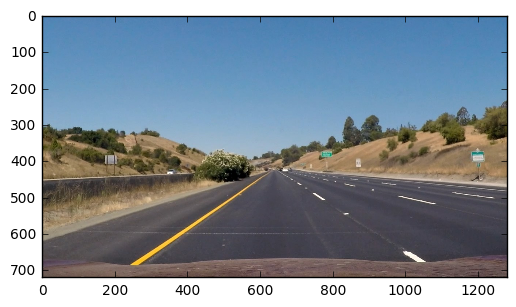

In [4]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


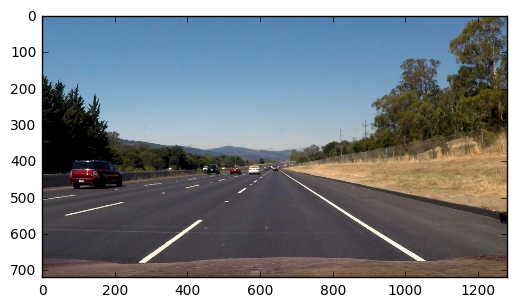

In [23]:
#reading in an image
image = mpimg.imread('test_images/straight_lines2.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [24]:
import math

def grayscale(image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
def canny(image, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(image, low_threshold, high_threshold)

def gaussian_blur(image, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def region_of_interest(image, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_image = np.zeros((*image.shape, 3), dtype=np.uint8)
    draw_lines(line_image, lines)
    return line_image

# Python 3 has support for cool math symbols.

def weighted_img(image, initial_image, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_image, α, image, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [25]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

## We write a function to lane mark all test images

In [26]:
def process_image(image):
    #read in and grayscale the image
    gray = grayscale(image)

    #define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 

    #this time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]), (440, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 2
    theta = np.pi/360 
    threshold = 20     
    min_line_len = 120 
    max_line_gap = 80    

    #run Hough on edge detected image
    #output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    #drawing the lines on the edge image
    result = weighted_img(line_image, image)
    return result

## We show the 6 "Test" images to see what kind of data we are dealing with

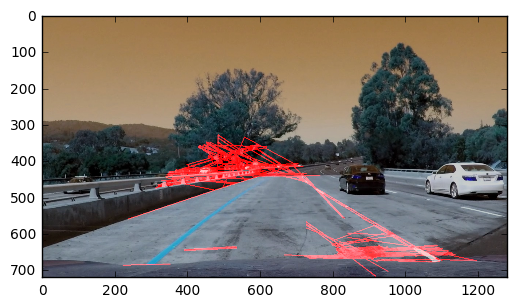

In [27]:
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(process_image(image))

In [28]:
copy = cv2.imwrite('test_images/test1.jpg', image)
print(copy)

True


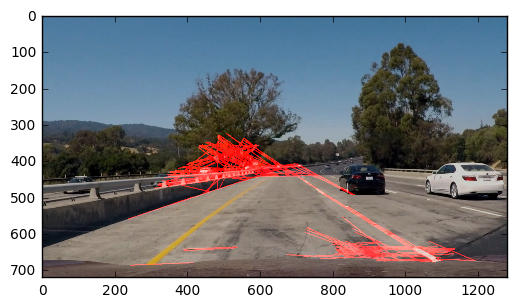

In [29]:
image = mpimg.imread('test_images/test2.jpg')
plt.imshow(process_image(image))

In [30]:
copy = cv2.imwrite('test_images/test2.jpg', image)
print(copy)

True


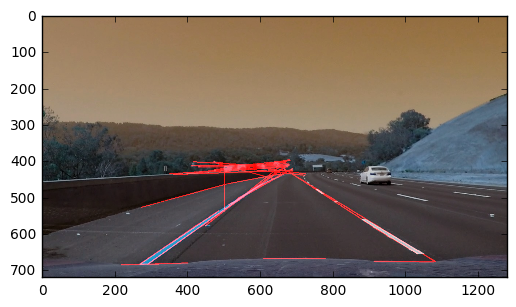

In [31]:
image = mpimg.imread('test_images/test3.jpg')
plt.imshow(process_image(image))

In [32]:
copy = cv2.imwrite('test_images/test3.jpg', image)
print(copy)

True


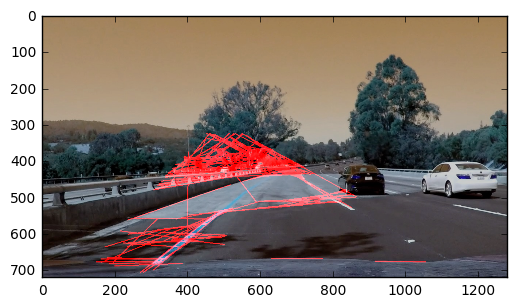

In [33]:
image = mpimg.imread('test_images/test4.jpg')
plt.imshow(process_image(image))

In [34]:
copy = cv2.imwrite('test_images/test4.jpg', image)
print(copy)

True


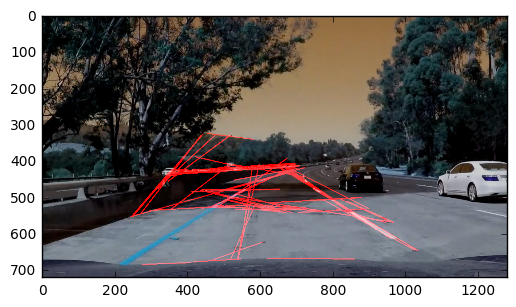

In [35]:
image = mpimg.imread('test_images/test5.jpg')
plt.imshow(process_image(image))

In [36]:
copy = cv2.imwrite('test_images/test5.jpg', image)
print(copy)

True


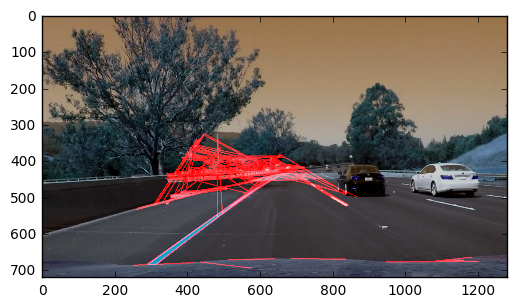

In [37]:
image = mpimg.imread('test_images/test6.jpg')
plt.imshow(process_image(image))

In [38]:
copy = cv2.imwrite('test_images/test6.jpg', image)
print(copy)

True


## We check if all new lane marked images are copied into the output folder

In [39]:
os.listdir("test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

## Markdown

## We import everything needed to edit/save/watch video clips

In [137]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Now we build a data pipeline to the video in the file directory to add the lane marks

In [138]:
def process_image(image):
    #read in and grayscale the image
    gray = grayscale(image)

    #define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 

    #this time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]), (440, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 2
    theta = np.pi/360 
    threshold = 20     
    min_line_len = 120 
    max_line_gap = 80    

    #run Hough on edge detected image
    #output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    #drawing the lines on the edge image
    result = weighted_img(line_image, image)

    return result

## Now we try the video with the solid white lane on the right at first

In [139]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 23.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 10.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [146]:
%matplotlib inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [147]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:27<00:00, 24.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 29.2 s


In [142]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_video_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

This project seemed quite hard for me at the beginning, this becease I know Python basics for data analysing and vizualisation, but I never thought that the step to code for engineering jobs was so hard, I noticed that I mis Computer Science and Computer Vision basic sklills/knowledge. The good news wat that Udacity offers dree introduction courses with great content and just for free, thats waht I like, open source tech and eduction iniatives benefitial to all willingly, so very proud to be part of this development, especcaly the October starters course, and I am very motivated and find it fun to prepare myself even better for module 2 & 3, I even asked the lead Engineer of Blackrock's algorith (She is a HBX Harvard classmate) for great resources to learn C++ and high speed coding to be prepared best way possible, and beceause I think it's fun to learn new coding languages.

About the project:
Great content and very challenging, but the office hours in slack and my fellow classmates were al of good help to get me started, now I am totally started up I have to admit that I find it hard this fun project is almost over by now. 

Data pipeline:

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [148]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:21<00:00,  9.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 24.7 s


In [149]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))